In [26]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats

# Path to modules
sys.path.append('../modules')

# Import my modules
from constants import ucsd_colors
from plotter import SeabornFig2Grid as sfg

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [27]:
path_to_data = '/home/dnash/SEAK_clim_data/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [28]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'hourly'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

# open precipitation data
fname = path_to_out + 'SEAK_precip_max_{0}_{1}.csv'.format(option, temporal_res)
prec_df = pd.read_csv(fname)
prec_df = prec_df.replace(0, np.NaN) # replace any instance of zero with nan to ignore dates with no precipitation

# open IVT data
df_lst = []
prec_clim_lst = []
percentile_lst_ivt = []
percentile_lst_prec = []
for i, community in enumerate(community_lst):
    fname = path_to_out + 'IVT_ERA5_{0}.csv'.format(community)
    ivt_df = pd.read_csv(fname)
    
    ## calculate IVT direction
    uvec = units.Quantity(ivt_df['uIVT'].values, "m/s")
    vvec = units.Quantity(ivt_df['vIVT'].values, "m/s")
    ivtdir = mpcalc.wind_direction(uvec, vvec)
    ivt_df['ivtdir'] = ivtdir
    ivt_df = ivt_df.drop(['Unnamed: 0'], axis=1) # drop unnecessary vars
    
    if temporal_res == 'hourly':
        ivt_df = ivt_df
    elif temporal_res == 'daily':
        ivt_df = ivt_df.set_index(pd.to_datetime(ivt_df['time'], format='%Y-%m-%d %H:%M:%S')) # reset the index as "date" 
        ivt_df = ivt_df.resample('1D').max()
        ivt_df = ivt_df.drop(['time'], axis=1)
        ivt_df = ivt_df.reset_index() # remove the index
    
    ## append AR data
    fname = path_to_out + 'SEAK_ardates_{0}.csv'.format(temporal_res)
    ar_df = pd.read_csv(fname) # read in AR dates

    # append AR dates to current df
    ivt_df['AR'] = ar_df.AR
    
    ## append impact data
    fname = path_to_out + 'SEAK_impactdates_{0}.csv'.format(temporal_res)
    impact_df = pd.read_csv(fname) # read in impact dates
    # append impact dates to current df
    ivt_df['impact'] = impact_df.IMPACT
    
    # ## append community precipitation data
    ivt_df['prec'] = prec_df[community]
    
    # reset the index as "time"
    ivt_df = ivt_df.set_index(pd.to_datetime(ivt_df['time']))
    
    # create day of year column
    ivt_df['day_of_year'] = ivt_df.index.dayofyear
    
    # calculate percentile rank for IVT and prec
    ivt_df['prec_{0}'.format(community)] = ivt_df['prec'].rank(pct=True)
    percentile_lst_prec.append(ivt_df['prec_{0}'.format(community)])
    ivt_df['ivt_{0}'.format(community)] = ivt_df['IVT'].rank(pct=True)
    percentile_lst_ivt.append(ivt_df['ivt_{0}'.format(community)])
    
    
    prec_clim = ivt_df.groupby(['day_of_year'])['prec'].mean()
    prec_clim_lst.append(prec_clim)
    df_lst.append(ivt_df)
    
df_lst[0]


,time,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir,AR,impact,prec,day_of_year,prec_Hoonah,ivt_Hoonah
time,,,,,,,,,,,,,,
1980-01-01 00:00:00,1980-01-01 00:00:00,41.78,58.00,-135.50,21.53,35.80,8.74,211.02,0,0,NaN,1,NaN,0.26
1980-01-01 01:00:00,1980-01-01 01:00:00,40.39,58.00,-135.50,18.53,35.89,9.08,207.30,0,0,NaN,1,NaN,0.25
1980-01-01 02:00:00,1980-01-01 02:00:00,40.47,58.00,-135.50,14.13,37.92,9.65,200.44,0,0,NaN,1,NaN,0.25
1980-01-01 03:00:00,1980-01-01 03:00:00,40.83,58.00,-135.50,11.13,39.28,10.39,195.82,0,0,NaN,1,NaN,0.25
1980-01-01 04:00:00,1980-01-01 04:00:00,41.56,58.00,-135.50,6.43,41.06,11.03,188.90,0,0,NaN,1,NaN,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019-12-31 19:00:00,69.06,58.00,-135.50,31.95,61.23,12.02,207.56,0,0,NaN,365,NaN,0.45
2019-12-31 20:00:00,2019-12-31 20:00:00,65.19,58.00,-135.50,27.47,59.11,11.76,204.93,0,0,NaN,365,NaN,0.42
2019-12-31 21:00:00,2019-12-31 21:00:00,63.88,58.00,-135.50,24.68,58.92,11.70,202.73,0,0,NaN,365,NaN,0.41


<AxesSubplot:>

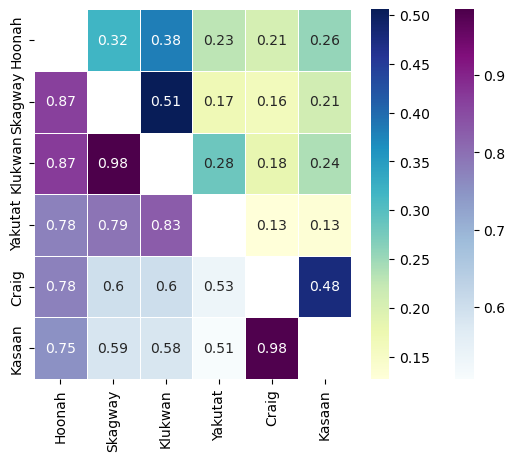

In [29]:
## make new_df that is just the percentile rank of each df
ivt_percentile = pd.concat(percentile_lst_ivt, axis=1)
prec_percentile = pd.concat(percentile_lst_prec, axis=1)
## create correlation table
ivt_corr = ivt_percentile.corr('pearson')
prec_corr = prec_percentile.corr('pearson')

matrix_0 = np.triu(ivt_corr)
matrix_1 = np.tril(prec_corr)

sns.heatmap(ivt_corr,annot=True,mask=matrix_0,cmap="BuPu", linewidth=.5, xticklabels=community_lst, yticklabels=community_lst)
sns.heatmap(prec_corr,annot=True,mask=matrix_1,cmap="YlGnBu", linewidth=.5, xticklabels=community_lst, yticklabels=community_lst)

In [4]:
# ## plot annual climatology
# prec_clim_lst[5].plot()

In [5]:
## some information on AR contribution
for i, df in enumerate(df_lst):
    print('On average in {0}...'.format(community_lst[i]))
    # number of days per year with precipitation > 0.1
    total_count = df.shape[0]
    calm_count = df.query("prec < 0.1").shape[0]
    # print('Of {} total observations, {} have less than 0.1 mm of precipitation.'.format(total_count, calm_count))
    x = (total_count - calm_count) / 40.
    print('...there are {0} days per year with precipitation greater than 0.1 mm per day'.format(x))
    # number of AR days per year
    idx = (df.AR == 1) & (df.prec > 0.1)
    tmp = df.loc[idx]
    ar_days = len(tmp) / 40.
    print('...there are {0} AR days per year'.format(ar_days))
    
    # AR contribution to total annual precipitation
    ## (total annual precip during AR days / total annual precip) * 100
    prec_clim = df.prec.groupby(df.index.year).sum() # get total precipitation per year
    ar_prec_clim = tmp.prec.groupby(tmp.index.year).sum() # get total precipitation per year during ARs
    ar_contr = (ar_prec_clim / prec_clim) *100
    avg_ar_contr = ar_contr.mean()
    print(u'...ARs contribute {:.2f}% to total annual precipitation'.format(avg_ar_contr))
    
    # number of days per year where precipitation is "extreme" > 95th percentile
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    extreme_count = df.query("prec > {0}".format(prec_thres)).shape[0]
    x = extreme_count / 40.
    print(u'...there are {:.2f} days per year with precipitation greater than {:.2f} mm per day'.format(x, prec_thres))
    
    ## number of AR days with extreme precipitation
    idx = (df.AR == 1) & (df.prec > prec_thres)
    tmp = df.loc[idx]
    ar_days_extreme = len(tmp) / 40.
    print('...{0} of which are AR days'.format(ar_days_extreme))
    
    ## AR contribution to extreme precipitation
    ## (total annual precip during extreme AR days / total annual precip during extreme precip) * 100
    extreme_prec = df.loc[(df.prec > prec_thres)]
    extreme_prec_clim = extreme_prec.prec.groupby(extreme_prec.index.year).sum() # get total precipitation during extreme events
    ar_prec_clim_extreme = tmp.prec.groupby(tmp.index.year).sum() # get total precipitation per year during extreme ARs
    ar_contr = (ar_prec_clim_extreme / extreme_prec_clim) *100
    avg_ar_contr = ar_contr.mean()
    print(u'...ARs contribute {:.2f}% to extreme precipitation'.format(avg_ar_contr))
    
    # number of impact days that are also ARs
    a = len(df.loc[(df['impact'] == 1)])
    b = len(df.loc[(df['impact'] == 1) & (df['AR'] == 1) ])
    print('...Out of the {0} days indicated as an impact day, {1} of them were associated with an AR'.format(a, b))

On average in Hoonah...
...there are 357.475 days per year with precipitation greater than 0.1 mm per day
...there are 112.525 AR days per year
...ARs contribute 65.11% to total annual precipitation
...there are 11.47 days per year with precipitation greater than 23.55 mm per day
...9.925 of which are AR days
...ARs contribute 86.47% to extreme precipitation
...Out of the 214 days indicated as an impact day, 157 of them were associated with an AR
On average in Skagway...
...there are 358.85 days per year with precipitation greater than 0.1 mm per day
...there are 98.0 AR days per year
...ARs contribute 68.54% to total annual precipitation
...there are 9.45 days per year with precipitation greater than 26.76 mm per day
...8.25 of which are AR days
...ARs contribute 88.68% to extreme precipitation
...Out of the 214 days indicated as an impact day, 157 of them were associated with an AR
On average in Klukwan...
...there are 355.5 days per year with precipitation greater than 0.1 mm per da

In [6]:
## getting bins for windrose based on percentiles
perc = [0., 0.10, 0.25, 0.5, 0.75, .95, 1.]
perc_lbl = ['0%', '10%', '25%', '50%', '75%', '95%', '100%']
prec_thres_lst = []
ivt_thres_lst = []
for i, df in enumerate(df_lst):
    sublist = []
    sublist_ivt = []
    for j, (thres, lbl) in enumerate(zip(perc, perc_lbl)):
        sublist.append(df['prec'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
        sublist_ivt.append(df['IVT'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
    flat_list = [item for l in sublist for item in l] # flatten the list
    flat_list_ivt = [item for l in sublist_ivt for item in l] # flatten the list
    prec_thres_lst.append(flat_list)
    ivt_thres_lst.append(flat_list_ivt)

In [7]:
# 95th percentile threshold for precipitation and IVT for ALL days
prec_thres = []
ivt_thres = []
for i, df in enumerate(df_lst):
    prec_thres.append(df['prec'].describe(percentiles=[.95]))
    ivt_thres.append(df['IVT'].describe(percentiles=[.95]))
    
    df['IVT'].describe(percentiles=[.95]).loc['95%']
    
non_ar_days = []
ar_days = []
ar_extreme = []
non_ar_extreme = []

for i, df in enumerate(df_lst):
    non_ar_days.append(len(df.loc[(df['prec'] < prec_thres[i]['95%']) & (df.AR == 0)]))
    ar_days.append(len(df.loc[(df['prec'] < prec_thres[i]['95%']) & (df.AR == 1)]))
    non_ar_extreme.append(len(df.loc[(df['prec'] > prec_thres[i]['95%']) & (df.AR == 0)]))
    ar_extreme.append(len(df.loc[(df['prec'] > prec_thres[i]['95%']) & (df.AR == 1)]))
                    
d = {'Community': community_lst, 'non-AR days': non_ar_days, 'AR days': ar_days, 'Extreme non-AR days': non_ar_extreme, 'Extreme AR days': ar_extreme}
table = pd.DataFrame(data=d)

table

,Community,non-AR days,AR days,Extreme non-AR days,Extreme AR days
0,Hoonah,4492,4227,62,397
1,Skagway,3472,3707,48,330
2,Klukwan,3173,3547,41,313
3,Yakutat,4228,4250,60,387
4,Craig,4717,4004,66,393
5,Kasaan,4485,3885,106,335


### Plot IVT/Precip Scatter and IVT direction and precipitation in windrose
Use https://gist.github.com/phobson/41b41bdd157a2bcf6e14 as an example

In [8]:
## Define a function that gives nice labels for precipitation ranges

def range_labels(bins):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('<{}'.format(right))
        elif right == bins[-1]:
            labels.append('>{}'.format(left))
        else:
            labels.append('{}-{}'.format(str(left[:-1]), right))

    return list(labels)

## Define a function to convert centered angles to left-edge radians
def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

## define wind rose function
def wind_rose(ax, rosedata, wind_dirs, legend_req, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])
    else:
        palette = sns.color_palette(palette, n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)
        
    # xticks = ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    if legend_req == True:
        leg = ax.legend(loc=(0.75, 0.1), ncol=1, fontsize=12, title='Percentile')
    
    return ax

def calc_rose(df, prec_bins, prec_labels, dir_bins, dir_labels):
    '''
    ### Determine the relative percentage of observation in each speed and direction bin
    Here's how we do it:

    - assign a precipitation bin for each row with pandas.cut
    - assign a direction bin for each row (again, pandas.cut)
    - unify the 360° and 0° bins under the 0° label
    - group the data simultaneously on both precipitation and direction bins
    - compute the size of each group
    - unstack (pivot) the speed bins into columns
    - fill missing values with 0
    - assign a "calm" column to be the total number of calm observations evenly distributed across all directions
    - sort the columns -- they are a catgerical index, so "calm" will be first (this is awesome!)
    - convert all of the counts to percentages of the total number of observations
    '''
    total_count = df.shape[0]
    # if temporal_res == 'hourly':
    #     calm_thres = 0.1
    # if temporal_res == 'daily':
    #     calm_thres = 2
    calm_thres = prec_bins[0]
    calm_count = df.query("prec < {0}".format(calm_thres)).shape[1]
    print('Of {} total observations, {} have less than {} mm of precipitation.'.format(total_count, calm_count, calm_thres))
    
    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=prec_labels, right=True))
          .assign(ivtdir_bins=lambda df: pd.cut(df['ivtdir'], bins=dir_bins, labels=dir_labels, right=False))
          .replace({'ivtdir_bins': {360: 0}})
          .groupby(by=['prec_bins', 'ivtdir_bins'])
          .size()
          .unstack(level='prec_bins')
          .fillna(0)
          # .assign(clear=lambda df: calm_count / df.shape[0])
          .sort_index(axis=1)
          .applymap(lambda x: x / total_count * 100))
        
    return df

IVT thres: 414.24 Prec thres: 23.55
IVT thres: 262.07 Prec thres: 26.76
IVT thres: 254.00 Prec thres: 22.34
IVT thres: 391.70 Prec thres: 42.11
IVT thres: 526.56 Prec thres: 23.82
IVT thres: 497.09 Prec thres: 24.97


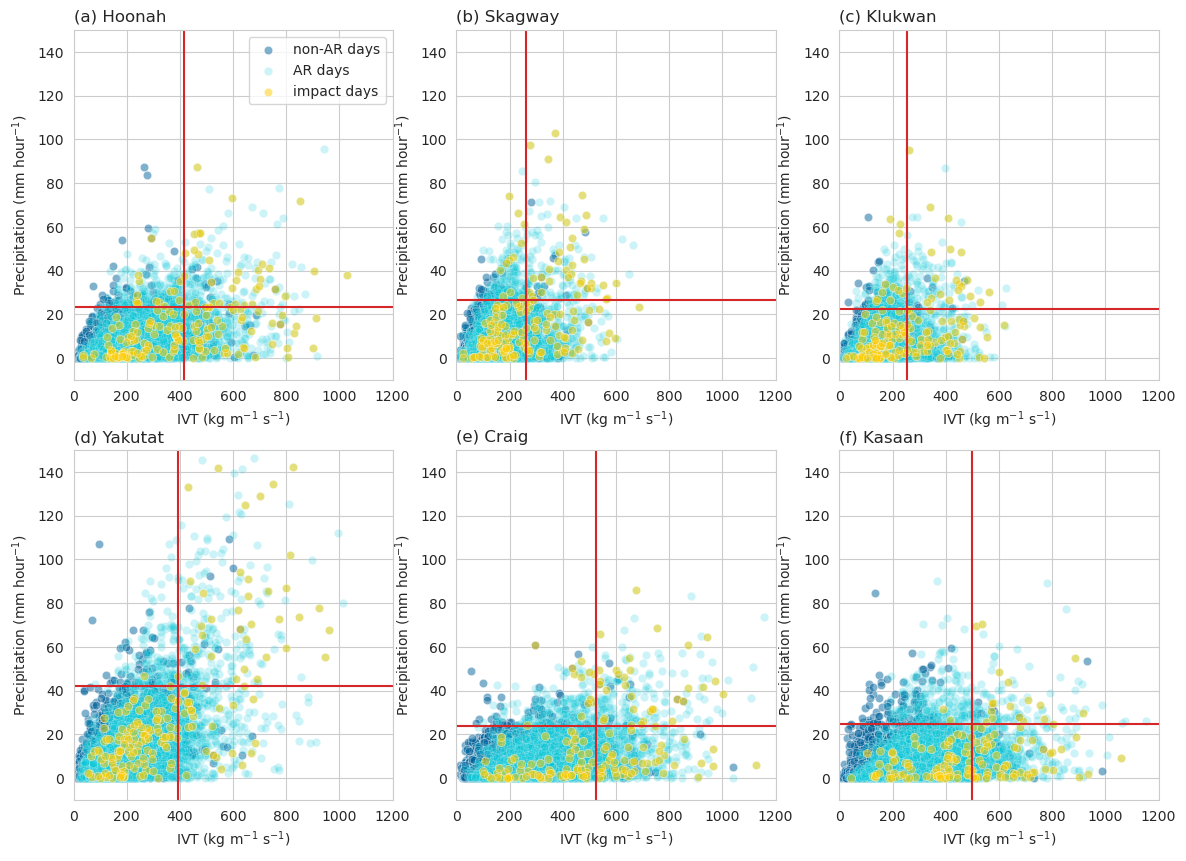

../figs/IVT-prec_scatter_daily.png


In [9]:
# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
colors = [ucsd_colors['navy'], ucsd_colors['aqua'], ucsd_colors['yellow'], ucsd_colors['grey']]
legend_lst = [True] + [False]*5
# legend_lst = [True]*6

fname = path_to_figs + 'IVT-prec_scatter_{0}'.format(temporal_res)
fmt = 'png'
nrows = 2
ncols = 3
nplots=nrows*ncols

fig = plt.figure(figsize=(14,10))

sns.set_style("whitegrid")

for i, df in enumerate(df_lst):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ## get 95th percentile of ivt and precip
    ivt_thres = df['IVT'].describe(percentiles=[.95]).loc['95%']
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%']
    
    # plot non-AR cases
    data = df.loc[(df.AR == 0)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[0]]), label='non-AR days'.format(n), alpha=0.5, legend=legend_lst[i])
    
    
    # plot AR cases
    data = df.loc[(df.AR == 1)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[1]]), label='AR days'.format(n), alpha=0.2, legend=legend_lst[i])
    
    
    
    print('IVT thres: {:,.2f}'.format(ivt_thres), 'Prec thres: {:,.2f}'.format(prec_thres))
    
    plt.axhline(y=prec_thres, color='tab:red', linestyle='-')
    plt.axvline(x=ivt_thres, color='tab:red', linestyle='-')
    
    ## plot Extreme AR days
    data = df.loc[(df['impact'] == 1)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[2]]), label='impact days'.format(n), alpha=0.5, legend=legend_lst[i])
    
#     ## plot Extreme non-AR days
#     data = df.loc[(df['prec'] > prec_thres) & (df.AR == 0)]
#     n = len(data)
#     g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[3]]), label='Extreme non-AR days (n={0})'.format(n), alpha=0.5, legend=legend_lst[i])
    
    
    ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
    if temporal_res == 'hourly':
        ax.set_ylim(-.5, 25)
        ax.set_xlim(0, 1200)
        y_lbl = 'Precipitation (mm hour$^{-1}$)'
    elif temporal_res == 'daily':
        ax.set_ylim(-10, 150)
        ax.set_xlim(0, 1200)
        y_lbl = 'Precipitation (mm hour$^{-1}$)'
        
    ax.set_title('({0}) {1}'.format(letter_lst[i], community_lst[i]), loc='left')
    # ax.set_title('(n={0})'.format(n), loc='right')
    
    ax.set_ylabel(y_lbl)
    
    if legend_lst == True:
        leg = ax.legend(loc='upper left', ncol=1)
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)

Of 5981 total observations, 12 have less than 0.00012207031 mm of precipitation.
Of 5981 total observations, 12 have less than 0.0010986328 mm of precipitation.


/tmp/ipykernel_16575/3029645860.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
/tmp/ipykernel_16575/3029645860.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


Of 5981 total observations, 12 have less than 0.00024414062 mm of precipitation.
Of 5981 total observations, 12 have less than 0.001953125 mm of precipitation.


/tmp/ipykernel_16575/3029645860.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
/tmp/ipykernel_16575/3029645860.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


Of 5981 total observations, 12 have less than 0.0014648438 mm of precipitation.
Of 5981 total observations, 12 have less than 0.0009765625 mm of precipitation.


/tmp/ipykernel_16575/3029645860.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
/tmp/ipykernel_16575/3029645860.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


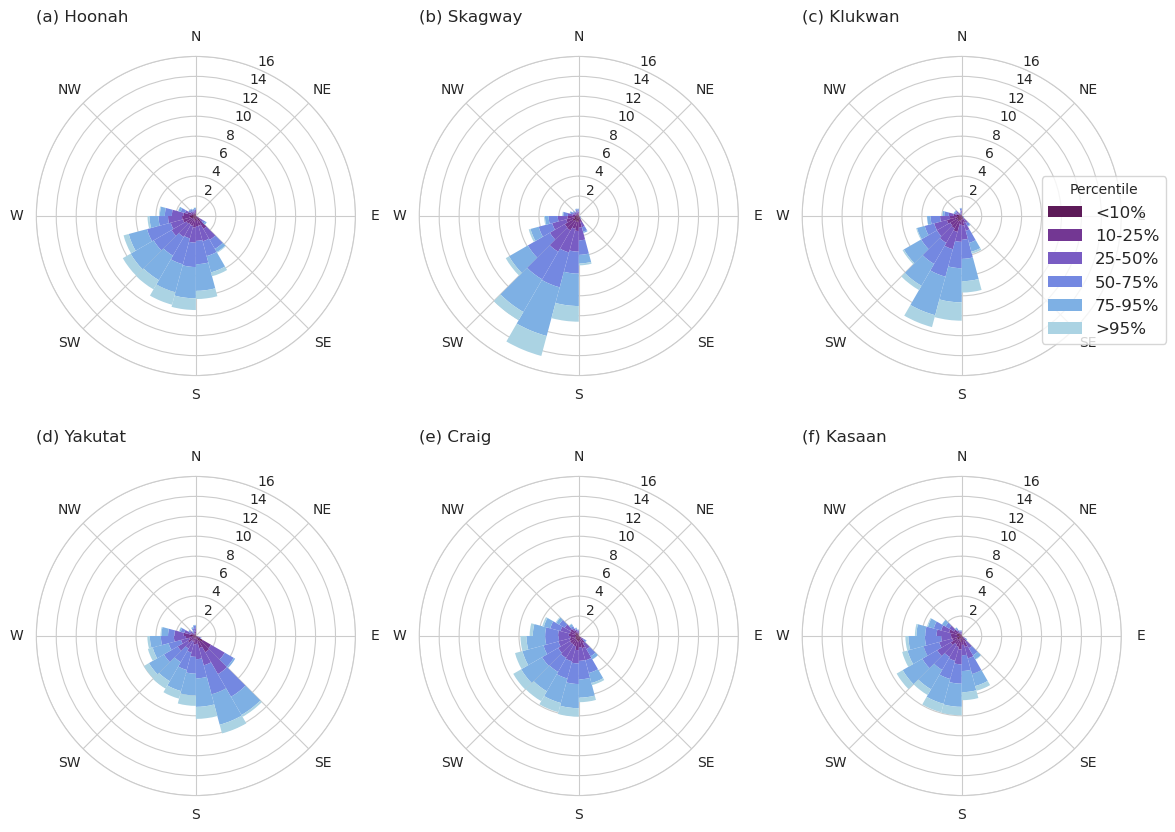

../figs/windrose_daily.png


In [10]:
## update plot so that it is 3 columns (ar type) by 1 rows (location of precip)
fname = path_to_figs + 'windrose_{0}'.format(temporal_res)
fmt = 'png'
nrows = 2
temporal_ress = 3
nplots=nrows*ncols

fig = plt.figure(figsize=(14,10))

sns.set_style("whitegrid")

#####################
### PLOT WINDROSE ###
#####################

## Define our bins and labels for speed and wind
if temporal_res == 'hourly':
    # prec_bins = [0, 0.01, 0.05, 0.25, 0.5, 0.75, 1, 2, 3, np.inf]
    rad_ticks = [1, 2, 3, 4, 5, 6]
elif temporal_res == 'daily':
    # prec_bins = [0, 2, 5, 10, 15, 20, 25, 30, 35, np.inf]
    rad_ticks = [2, 4, 6, 8, 10, 12, 14, 16]


dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

## use wind rose function
directions = np.arange(0, 360, 15)
legend_req = [False, False, True] + [False]*3

## loop through each AR type to plot wind rose
for i, df in enumerate(df_lst):
    prec_bins = prec_thres_lst[i]
    prec_labels = range_labels(perc_lbl)

    ax = fig.add_subplot(nrows, ncols, i+1, projection='polar')
    
    # plot AR cases
    data = df.loc[(df.AR == 1)]
    rose = calc_rose(data, prec_bins, prec_labels, dir_bins, dir_labels)
    
    ax = wind_rose(ax, rose, directions, legend_req[i], palette="cmo.dense_r")
    
    ax.set_rticks(rad_ticks)  # Less radial ticks
    ax.set_title('({0}) {1}'.format(letter_lst[i], community_lst[i]), loc='left')

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)

In [69]:
def assign_percentiles(df, prec_bins, ivt_bins, perc_labels):
    '''
    ### Determine the percentile group for precipitation and ivt

    - assign a precipitation bin for each row with pandas.cut
    - assign a ivt bin for each row with pandas.cut
    '''
    
    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=perc_labels, right=True))
            .assign(ivt_bins=lambda df: pd.cut(df['IVT'], bins=ivt_bins, labels=perc_labels, right=True))
         )
    
    df = df.rename(columns={"prec_bins": "Precipitation Percentiles", "ivt_bins": "IVT Percentiles"})
        
    return df

def community_heatmap_values(df, perc_lbl):
    denom = np.empty((6, 6), float)
    num = np.empty((6, 6), float)
    extreme_prec_AR = np.empty((6), float)
    extreme_ivt_AR = np.empty((6), float)
    for i, perc_i in enumerate(perc_lbl):
        ## get total number of precipitation days within each percentile bin
        idx = (df['Precipitation Percentiles'] == perc_i)
        denom_val = len(df.loc[idx])
        

        ## get total number of IVT days within the same percentile bin
        
        for j, perc_j in enumerate(perc_lbl):
            idx = (df['Precipitation Percentiles'] == perc_i) & (df['IVT Percentiles'] == perc_j)
            num_val = len(df.loc[idx])
            num[j, i] = num_val # put numerator in array
            
            # put denominator in array
            denom[j, i] = denom_val # put denominator in array
            
            
        ## get fraction of AR days that are also 95th percentile precip
        idx = (df['Precipitation Percentiles'] == perc_i) & (df['AR'] == 1)
        AR_num = len(df.loc[idx])
        extreme_prec_AR[i] = (AR_num/denom_val)*100

        ## get fraction of AR days that are also 95th percentile IVT
        idx = (df['IVT Percentiles'] == perc_i)
        denom_val = len(df.loc[idx])
        idx = (df['IVT Percentiles'] == perc_i) & (df['AR'] == 1)
        AR_num = len(df.loc[idx])
        extreme_ivt_AR[i] = (AR_num/denom_val)*100
        
    heatmap_vals = (num/denom)*100
    
    return heatmap_vals, extreme_prec_AR, extreme_ivt_AR


def create_heatmap_plot(heatmap_vals, extreme_prec_AR, extreme_ivt_AR, ax, axhistx, axhisty, tck_lblx, tck_lbly, bar_tck):

    # no labels, remove spines
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histx.set_ylim(0, 99)

    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.set_ylim(0, 99)
    
    ax_histx.bar(x = bar_tck, height=extreme_prec_AR, align='edge', color='#DAE6E6')
    ax_histy.barh(range(len(bar_tck)), extreme_ivt_AR, align='edge', color='#DAE6E6')
    
    ## add heatmap
    g = sns.heatmap(heatmap_vals, cmap=cmo.dense, annot=True, linewidth=.5, xticklabels=tck_lblx, yticklabels=tck_lbly, ax=ax, cbar=False)
    # apply tick parameters    
    ax.tick_params(direction='out', 
                   labelsize=8, 
                   length=4, 
                   pad=2, 
                   color='black',
                   labelrotation=0.0)

    

## Create panel plot of percentile histogram plots

[37.73173391 39.36092956 40.84568439 51.54684096 66.43051771 86.49237473] [ 7.32876712 11.5419708  24.28806134 48.79518072 77.85763176 92.6128591 ]
[41.16094987 41.87279152 46.34533898 54.63208047 67.04169424 87.3015873 ] [ 9.24657534 14.37043796 27.40963855 46.13910186 74.50376454 91.38166895]
[41.35977337 42.4128181  45.81447964 55.90729226 71.145686   88.4180791 ] [ 9.31506849 15.10036496 26.09529025 46.49507119 74.91444216 92.20246238]
[33.632287   39.74645787 44.99775684 53.11519498 68.89013453 86.57718121] [11.16438356 16.1040146  25.13691128 45.78313253 75.01711157 93.43365253]
[36.16557734 37.79069767 39.31214628 46.92542521 63.83442266 85.62091503] [ 6.36986301 12.08941606 21.54983571 48.63088719 81.24572211 93.84404925]
[36.32236095 38.60711582 40.8987744  46.73024523 63.84790011 75.96371882] [ 7.46575342 11.77007299 22.42606791 48.41182913 80.15058179 93.70725034]


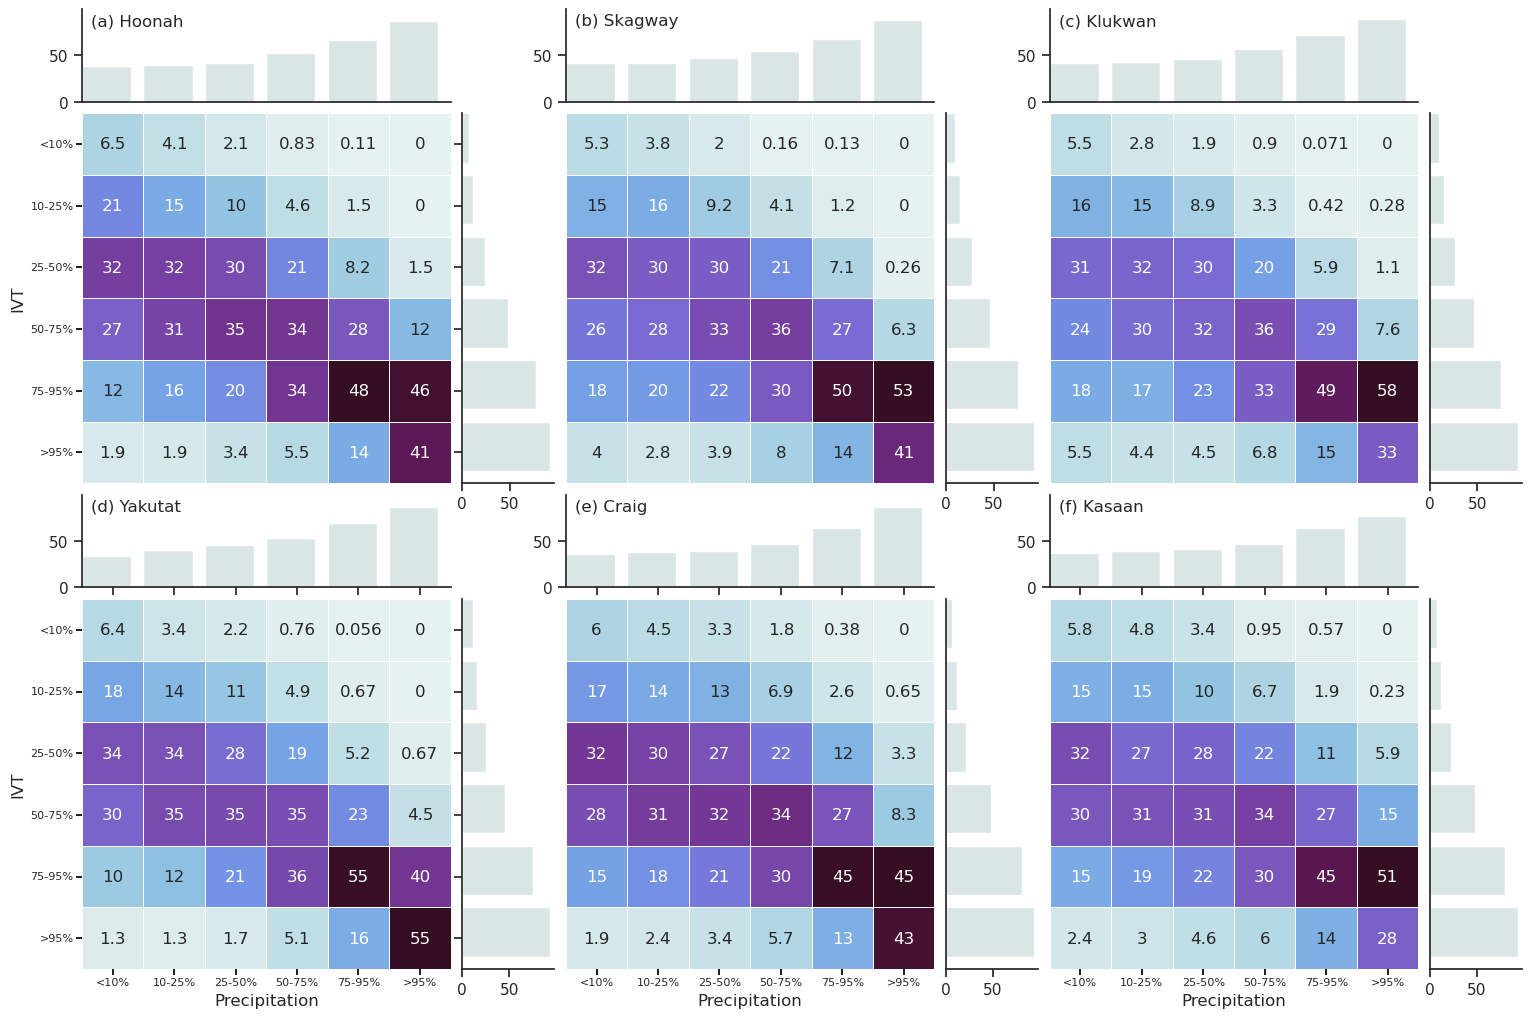

../figs/percentile_bins_daily.png


In [72]:
fname = path_to_figs + 'percentile_bins_{0}'.format(temporal_res)
fmt = 'png'

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

# Start with a square Figure. - then multiple each by the number of rows and columns you want of each full panel
nrows = 2
ncols = 3
# lists of axes locations - I couldn't math this out, but this works
ax_lst = [[1, 0], [1, 2], [1, 4], [3, 0], [3, 2], [3, 4]]
axhistx_lst = [[0, 0], [0, 2], [0, 4], [2, 0], [2, 2], [2, 4]]
axhisty_lst = [[1, 1], [1, 3], [1, 5], [3, 1], [3, 3], [3, 5]]

tcklblx_lst = [False, False, False, range_labels(perc_lbl), range_labels(perc_lbl), range_labels(perc_lbl)]
tcklbly_lst = [range_labels(perc_lbl), False, False, range_labels(perc_lbl), False, False]

xlbl_lst = ['']*3 + ['Precipitation']*3
ylbl_lst = ['IVT', '', '']*2

sns.set_theme(style="ticks")

fig = plt.figure(figsize=(6*ncols, 6*nrows))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2*nrows, 2*ncols,  width_ratios=[4, 1]*ncols, height_ratios=[1, 4]*nrows,
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)


for i, df in enumerate(df_lst):
    # get percentile values
    perc_prec = prec_thres_lst[i]
    perc_ivt = ivt_thres_lst[i]
    # giving each df a column for percentile bins for precip and ivt
    tmp = assign_percentiles(df, prec_thres_lst[i], ivt_thres_lst[i], range_labels(perc_lbl))
    heatmap_vals, extreme_prec_AR, extreme_ivt_AR = community_heatmap_values(tmp, range_labels(perc_lbl))
    print(extreme_prec_AR, extreme_ivt_AR)
    
    # Create the Axes.
    ax = fig.add_subplot(gs[ax_lst[i][0], ax_lst[i][1]])
    ax_histx = fig.add_subplot(gs[axhistx_lst[i][0], axhistx_lst[i][1]], sharex=ax)
    ax_histy = fig.add_subplot(gs[axhisty_lst[i][0], axhisty_lst[i][1]], sharey=ax)
    
    # plot the heatmap and marginal bar charts
    create_heatmap_plot(heatmap_vals, extreme_prec_AR, extreme_ivt_AR, ax, axhistx, axhisty, tcklblx_lst[i], tcklbly_lst[i], range_labels(perc_lbl))
    ax.set_xlabel(xlbl_lst[i])
    ax.set_ylabel(ylbl_lst[i])
    
    # plot title
    titlestring = '({0}) {1}'.format(letter_lst[i], community_lst[i])
    ax_histx.text(0.025, 1.27, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)
    
    
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)

## Calculate Correlation between precipitation percentiles

In [75]:
# stats.percentileofscore(df['prec'], 4, kind='rank')
# df.assign(prec_percentile_score=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=perc_labels, right=True))

# df.apply(stats.percentileofscore, axis=1)

new_df = df.apply(lambda x: stats.percentileofscore(df['prec'], x, kind='rank') if x.name == 'prec' else x)

In [76]:
new_df

,time,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir,AR,impact,prec,day_of_year
time,,,,,,,,,,,,
1980-01-01,1980-01-01,164.75,55.50,-132.50,0.80,164.32,13.54,180.96,0,0,NaN,1
1980-01-02,1980-01-02,239.04,55.50,-132.50,-23.86,204.67,13.86,171.66,0,0,NaN,2
1980-01-03,1980-01-03,80.21,55.50,-132.50,56.06,62.17,9.50,272.89,0,0,NaN,3
1980-01-04,1980-01-04,53.70,55.50,-132.50,52.36,-4.46,6.09,339.17,0,0,NaN,4
1980-01-05,1980-01-05,213.94,55.50,-132.50,147.53,-33.62,9.21,347.98,1,0,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019-12-27,258.86,55.50,-132.50,98.96,251.47,16.78,259.34,0,1,NaN,361
2019-12-28,2019-12-28,572.13,55.50,-132.50,133.45,564.42,21.56,230.89,0,0,NaN,362
2019-12-29,2019-12-29,201.24,55.50,-132.50,73.42,196.90,14.20,223.35,0,0,NaN,363


In [79]:
df['prec']

time
1980-01-01    3.19
1980-01-02    5.98
1980-01-03    0.13
1980-01-04    0.05
1980-01-05     NaN
              ... 
2019-12-27    5.59
2019-12-28   32.34
2019-12-29    1.80
2019-12-30    8.21
2019-12-31   10.22
Name: prec, Length: 14610, dtype: float64

In [80]:
df['percent_rank'] = df['prec'].rank(pct=True)

In [81]:
df

,time,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir,AR,impact,prec,day_of_year,percent_rank
time,,,,,,,,,,,,,
1980-01-01,1980-01-01,164.75,55.50,-132.50,0.80,164.32,13.54,180.96,0,0,3.19,1,0.42
1980-01-02,1980-01-02,239.04,55.50,-132.50,-23.86,204.67,13.86,171.66,0,0,5.98,2,0.59
1980-01-03,1980-01-03,80.21,55.50,-132.50,56.06,62.17,9.50,272.89,0,0,0.13,3,0.04
1980-01-04,1980-01-04,53.70,55.50,-132.50,52.36,-4.46,6.09,339.17,0,0,0.05,4,0.02
1980-01-05,1980-01-05,213.94,55.50,-132.50,147.53,-33.62,9.21,347.98,1,0,NaN,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019-12-27,258.86,55.50,-132.50,98.96,251.47,16.78,259.34,0,1,5.59,361,0.57
2019-12-28,2019-12-28,572.13,55.50,-132.50,133.45,564.42,21.56,230.89,0,0,32.34,362,0.98
2019-12-29,2019-12-29,201.24,55.50,-132.50,73.42,196.90,14.20,223.35,0,0,1.80,363,0.29
